# 🏗️ Problem 1 — Settlements Optimization (QUBO + QAOA / VQE)

În această problemă construim tabla Catan, alegem intersecțiile candidate pentru așezări, formulăm un **QUBO** care maximizează potențialul (probabilitățile de zar ale terenurilor adiacente) și respectă regula *distanță ≥ 2* între așezări.

Vom rula apoi algoritmi cuantici:
- **QAOA** (cu Qiskit)
- **VQE** (cu PennyLane)

și vom compara soluțiile.

In [2]:
# --- Imports & setup ---
from pathlib import Path
import sys, os, numpy as np
import matplotlib.pyplot as plt

# Adaugă 'src' în sys.path
for r in [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]:
    if (r / 'src').exists():
        sys.path.append(str(r / 'src'))
        break

from catan.utils import set_seed, print_section, cprint, Colors
from catan.board import board_for_qubits
from catan.viz import plot_board, plot_settlement_selection, highlight_nodes
from catan.encodings.qubo import build_settlement_qubo
from catan.encodings.qiskit_qaoa import run_qaoa_qubo, plot_energy_landscape
from catan.encodings.pennylane_vqe import run_vqe_qubo, plot_vqe_convergence, plot_vqe_probabilities

In [3]:
# --- Parameters ---
N_QUBITS = 4     # variabile binare / qubiți (intersecții)
SEED = 42          # reproducibilitate
METHOD = 'qaoa'    # 'qaoa' sau 'vqe'

set_seed(SEED)
print_section(f"Quantum Catan - P1 (N_QUBITS={N_QUBITS}, METHOD={METHOD})")


=== Quantum Catan - P1 (N_QUBITS=4, METHOD=qaoa) ===


Tiles=19, Nodes=59, Edges=76
Selected 4 candidate nodes


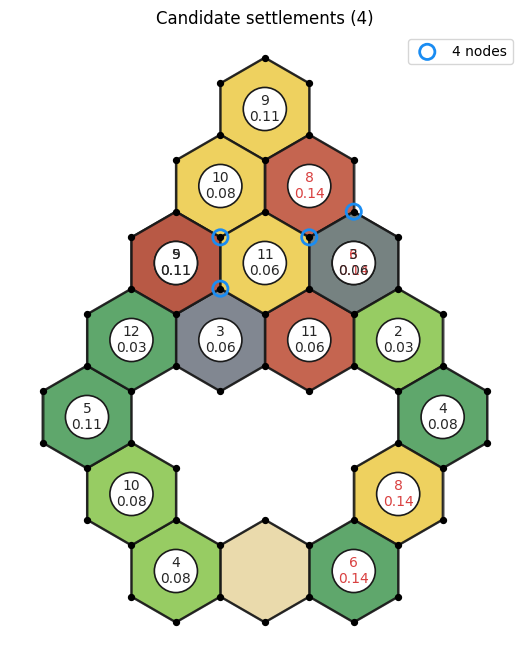

In [4]:
# --- Build Board and Select Nodes ---
board, selected_nodes, var_map = board_for_qubits(n_qubits=N_QUBITS, mode="settlement", seed=SEED)
print(f"Tiles={board.n_tiles}, Nodes={board.n_nodes}, Edges={board.n_edges}")
print(f"Selected {len(selected_nodes)} candidate nodes")

# Vizualizare tabla + nodurile candidate
fig, ax = plot_settlement_selection(board, selected_nodes, title=f"Candidate settlements ({N_QUBITS})")
plt.show()

In [5]:
# --- Build QUBO ---
Q_model = build_settlement_qubo(board, selected_nodes)
Q = Q_model.Q
print_section("QUBO built")
print(f"Matrix shape: {Q.shape}")
print(f"Example diag values: {np.round(np.diag(Q)[:10],4)}")


=== QUBO built ===
Matrix shape: (4, 4)
Example diag values: [-0.3889 -0.3611 -0.3333 -0.3333]


In [6]:
# --- Run Solver ---
if METHOD.lower() == 'qaoa':
    result = run_qaoa_qubo(Q, reps=1, optimizer='COBYLA', shots=256, seed=SEED)
    bitstring = result['best_bitstring']
    energy = result['best_energy']
    cprint(f"[QAOA] Done → best={bitstring}, energy={energy:.6f}", Colors.GREEN)
else:
    result = run_vqe_qubo(Q, layers=2, steps=100, lr=0.2, optimizer='adam')
    bitstring = result['best_bitstring']
    energy = result['best_energy']
    cprint(f"[VQE] Done → best={bitstring}, energy={energy:.6f}", Colors.GREEN)

[QAOA] Done in 1.16s | Best=0110, Energy=-0.694444
[QAOA] Done → best=0110, energy=-0.694444


Chosen node IDs: [9, 10]


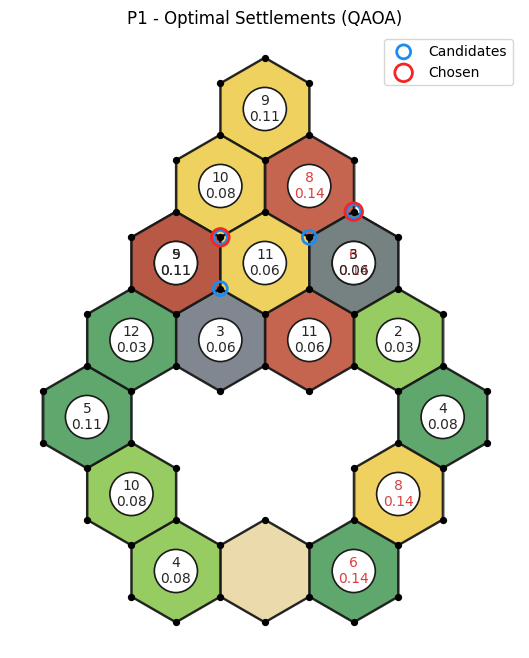

In [7]:
# --- Visualize Solution ---
chosen_nodes = [Q_model.id_of[i] for i, b in enumerate(bitstring[::-1]) if b == '1']
cprint(f"Chosen node IDs: {chosen_nodes}", Colors.YELLOW)

fig, ax = plot_board(board)
highlight_nodes(board, selected_nodes, ax=ax, color=(0.10, 0.55, 0.95), size=100, label="Candidates")
highlight_nodes(board, chosen_nodes, ax=ax, color=(0.95, 0.15, 0.15), size=160, label="Chosen")
ax.set_title(f"P1 - Optimal Settlements ({METHOD.upper()})")
plt.show()

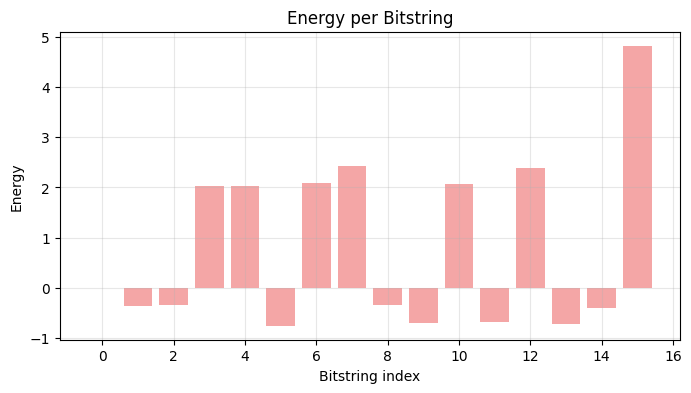

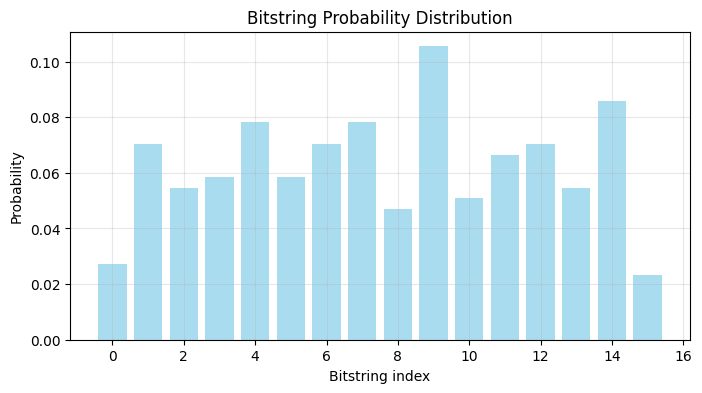

In [8]:
# --- Energy / Probability analysis ---
if METHOD.lower() == 'qaoa':
    plot_energy_landscape(result['bitstrings'], Q)
else:
    plot_vqe_convergence(result['energy_history'])
    plot_vqe_probabilities(result['probabilities'], Q)

In [9]:
# --- Save artefacts ---
out = Path('data'); out.mkdir(exist_ok=True)
np.save(out / 'p1_Q.npy', Q)
with open(out / 'p1_best.txt', 'w') as f:
    f.write(f'METHOD={METHOD}\nbitstring={bitstring}\nenergy={energy}\n')
cprint(f'Saved results to {out}/p1_Q.npy and p1_best.txt', Colors.GREEN)

Saved results to data/p1_Q.npy and p1_best.txt
